In [1]:
import heapq
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def update_plot(frame, grid, paths):
    plt.cla()
    plt.imshow(grid, cmap='binary')

    for i, path in enumerate(paths):
        if frame < len(path):
            x, y = path[frame]
            plt.text(y, x, str(i), ha='center',
                     va='center', fontsize=10, color='red')

    # plt.gca().invert_yaxis()
    plt.xticks(range(len(grid[0])))
    plt.yticks(range(len(grid)))


In [13]:
import heapq
from collections import defaultdict, deque

class Node:
    def __init__(self):
        self.plan = {}  # Plan for each agent
        self.constraints = set()  # Constraints on agents
        self.priority_order = set()  # Partial order of agent priorities
        self.cost = float('inf')  # Cost of the plan

def low_level_search(start, goal, grid, constraints, agent_id, max_time=100):
    """A* search for a single agent that respects constraints."""
    def heuristic(pos):
        return abs(pos[0] - goal[0]) + abs(pos[1] - goal[1])

    def get_neighbors(pos):
        x, y = pos
        neighbors = [(x, y)]
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < len(grid) and 0 <= ny < len(grid[0]) and grid[nx][ny] == 0:
                neighbors.append((nx, ny))
        return neighbors

    open_set = []
    heapq.heappush(open_set, (heuristic(start), 0, start, []))
    visited = set()

    while open_set:
        _, g, current, path = heapq.heappop(open_set)
        if (current, len(path)) in visited:
            continue
        visited.add((current, len(path)))

        # Goal check
        if current == goal:
            return path + [current]

        # Expand neighbors
        for neighbor in get_neighbors(current):
            conflict = False

            for c in constraints:
                if c['agent'] != agent_id:
                    if c['type'] == 'vertex':
                        # Check for vertex conflict
                        if c['pos'] == neighbor and c['time'] == g + 1:
                            conflict = True
                            break
                    elif c['type'] == 'edge':
                        # Check for edge conflict
                        
                        if current != neighbor:
                            if c['edge'] == (neighbor, current) and c['time'] == g + 1:
                                conflict = True
                                break
                        # # Also check reverse edge for wait actions being misinterpreted as conflicts
                        # if c['edge'] == (neighbor, current) and c['time'] == g + 1:
                        #     conflict = True
                            # break

            if not conflict:
                heapq.heappush(open_set, (g + heuristic(neighbor), g + 1, neighbor, path + [current]))

    return None  # No path found

def detect_collision(plan):
    """Detect the first vertex or edge collision in the plan."""
    time_dict = defaultdict(list)
    edge_dict = defaultdict(list)

    for agent, path in plan.items():
        for t, pos in enumerate(path):
            time_dict[(pos, t)].append(agent)

            agents = time_dict[(pos, t)]
            if len(agents) > 1:
                return {'type': 'vertex', 'time': t, 'pos': pos, 'agents': agents}
            
            if t < len(path) - 1:
                edge = (path[t], path[t + 1])
                if edge[0] != edge[1]:
                    edge_dict[(edge, t + 1)].append(agent)

                    agents = edge_dict[(edge, t + 1)]
                    reverse_edge = ((edge[1], edge[0]), t+1)
                    if reverse_edge in edge_dict.keys():
                        agents += edge_dict[reverse_edge]
                        return {'type': 'edge', 'time': t, 'edge': edge, 'agents': agents}

    # for (pos, t), agents in time_dict.items():
    #     if len(agents) > 1:
    #         return {'type': 'vertex', 'time': t, 'pos': pos, 'agents': agents}
        
    # for (edge, t), agents in edge_dict.items():
    #     reverse_edge = ((edge[1], edge[0]), t)
    #     if reverse_edge in edge_dict.keys():
    #         agents += edge_dict[reverse_edge]
    #         return {'type': 'edge', 'time': t, 'edge': edge, 'agents': agents}

    return None  # No collisions detected

def update_plan(node, agent_id, grid, starts, goals):
    """Update the plan for an agent considering the current priority order."""
    # Topological sorting of priorities
    graph = defaultdict(list)
    # for agent in range(len(starts)):
    #     graph[agent] = []

    for a, b in node.priority_order:
        graph[a].append(b)
        if b not in graph:
            graph[b] = []

    try:
        sorted_agents = topological_sort(graph)
    except ValueError:
        return False  # Cyclic dependency in priorities
    
    constraints = []  # Constraints are derived from priorities
    higher_priority_agents = sorted_agents[:sorted_agents.index(agent_id)]
    for higher_agent in higher_priority_agents:
        higher_agent_path = node.plan[higher_agent]
        for t, pos in enumerate(higher_agent_path):
            constraints.append({'type': 'vertex', 'agent': higher_agent, 'pos': pos, 'time': t})
            if t < len(higher_agent_path) - 1:
                edge = (higher_agent_path[t], higher_agent_path[t + 1])
                constraints.append({'type': 'edge', 'agent': higher_agent, 'edge': edge, 'time': t + 1})
    
    lower_priority_agents = sorted_agents[sorted_agents.index(agent_id):]
    for agent in lower_priority_agents:
        # Perform low-level search for the current agent
        path = low_level_search(starts[agent], goals[agent], grid, constraints, agent)
        if path is None:
            return False  # No solution found for the current agent
        node.plan[agent] = path
    
        for time, pos in enumerate(node.plan[agent]):
            # Add a vertex constraint
            constraints.append({'type': 'vertex', 'agent': agent, 'pos': pos, 'time': time})
            # Add an edge constraint (to prevent moving into `a`'s next position)
            if time < len(node.plan[agent]) - 1:
                edge = (node.plan[agent][time], node.plan[agent][time + 1])
                constraints.append({'type': 'edge', 'agent': agent, 'edge': edge, 'time': time + 1})

    return True

def topological_sort(graph):
    """Topological sort on a directed graph."""
    in_degree = {node: 0 for node in graph}
    for node in graph:
        for neighbor in graph[node]:
            in_degree[neighbor] += 1

    zero_in_degree = deque([node for node in graph if in_degree[node] == 0])
    sorted_order = []

    while zero_in_degree:
        current = zero_in_degree.popleft()
        sorted_order.append(current)
        for neighbor in graph[current]:
            in_degree[neighbor] -= 1
            if in_degree[neighbor] == 0:
                zero_in_degree.append(neighbor)

    if len(sorted_order) == len(graph):
        return sorted_order
    else:
        raise ValueError("Graph has a cycle and cannot be topologically sorted.")


def priority_based_search(grid, starts, goals):
    """Main PBS algorithm."""
    root = Node()
    for i, start in enumerate(starts):
        path = low_level_search(start, goals[i], grid, [], i)
        if path is None:
            return "No Solution"
        root.plan[i] = path

    root.cost = sum(len(path) for path in root.plan.values())
    stack = [root]

    while stack:
        node = stack.pop()
        collision = detect_collision(node.plan)

        if not collision:
            return node.plan, node.priority_order

        new_nodes = []
        ai, aj = collision['agents'][:2]  # Handle the first collision
        for agent in [ai, aj]:
            # LIST ← topological sorting on partially ordered set ({i} ∪ {j|i ≺N j}, ≺≺≺N )

            new_node = Node()
            new_node.plan = dict(node.plan)
            new_node.priority_order = set(node.priority_order)
            new_node.priority_order.add((aj, ai) if agent == ai else (ai, aj))

            success = update_plan(new_node, agent, grid, starts, goals)
            if success:
                new_node.cost = sum(len(path) for path in new_node.plan.values())
                new_nodes.append(new_node)

        # sort non-increasing order of cost
        new_nodes.sort(key=lambda x: x.cost, reverse=True)
        stack.extend(new_nodes)

    return "No Solution"

# Example Usage
if __name__ == "__main__":
    grid = [
        [0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0],
    ]

    starts = [(4, 0), (4, 1)]
    goals = [(0, 4), (4, 0)]

    paths, priority_order = priority_based_search(grid, starts, goals)

    paths = paths.values()

    if paths:
        for i, path in enumerate(paths):
            print(f"Agent {i}: {path}")
    else:
        print("No solution found")


Agent 0: [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (3, 4), (2, 4), (1, 4), (0, 4)]
Agent 1: [(4, 1), (3, 1), (4, 1), (4, 0)]


In [10]:
smoothness = 10
new_paths = []
for path in paths:
    new_path = []
    for i in range(len(path)-1):
        new_path.append(path[i])
        for j in range(1, smoothness):
            dir_y = path[i+1][0] - path[i][0]
            dir_x = path[i+1][1] - path[i][1]
            new_c = (path[i][0]+(dir_y/smoothness*j), path[i][1]+(dir_x/smoothness*j))
            new_path.append(new_c)
    new_paths.append(new_path)

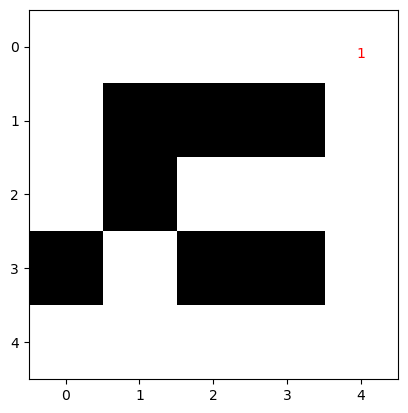

In [11]:
fig = plt.figure()
ani = FuncAnimation(fig, update_plot, frames=max(len(path)
                    for path in new_paths), fargs=(grid, new_paths), interval=50)
ani.save('paths.gif', writer='imagemagick')
plt.show()